In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
trainDF = pd.read_csv('train.csv')
trainDF.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [3]:
testDF = pd.read_csv('test.csv')
testDF.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [4]:
concatDF = pd.concat([trainDF,testDF])

# concatDF.loc[concatDF['Gender']=='Male',['Gender']]=0
# concatDF.loc[concatDF['Gender']=='Female',['Gender']]=1
# concatDF['Gender']=concatDF['Gender'].astype(float)
concatDF = pd.get_dummies(concatDF ,columns=['Gender'])

concatDF['Age']=concatDF['Age']/concatDF['Age'].max()

# concatDF.loc[concatDF['Vehicle_Age']=='< 1 Year',['Vehicle_Age']]=0
# concatDF.loc[concatDF['Vehicle_Age']=='1-2 Year',['Vehicle_Age']]=0.5
# concatDF.loc[concatDF['Vehicle_Age']=='> 2 Years',['Vehicle_Age']]=1
# concatDF['Vehicle_Age']=concatDF['Vehicle_Age'].astype(float)
concatDF = pd.get_dummies(concatDF ,columns=['Vehicle_Age'])

concatDF['Annual_Premium']=concatDF['Annual_Premium']/concatDF['Annual_Premium'].max()

concatDF['Vintage']=concatDF['Vintage']/concatDF['Vintage'].max()

# concatDF.loc[concatDF['Vehicle_Damage']=='No',['Vehicle_Damage']]=0
# concatDF.loc[concatDF['Vehicle_Damage']=='Yes',['Vehicle_Damage']]=1
# concatDF['Vehicle_Damage']=concatDF['Vehicle_Damage'].astype(float)
concatDF = pd.get_dummies(concatDF ,columns=['Vehicle_Damage'])

concatDF['id']=concatDF['id'].astype(str)

# concatDF['Driving_License']=concatDF['Driving_License'].astype(float)
concatDF = pd.get_dummies(concatDF ,columns=['Driving_License'])

# concatDF['Previously_Insured']=concatDF['Previously_Insured'].astype(float)
concatDF = pd.get_dummies(concatDF ,columns=['Previously_Insured'])

concatDF = pd.get_dummies(concatDF ,columns=['Region_Code'])
# concatDF = concatDF.drop(columns=['Region_Code'])

concatDF = pd.get_dummies(concatDF ,columns=['Policy_Sales_Channel'])
# concatDF = concatDF.drop(columns=['Policy_Sales_Channel'])

concatDF = pd.get_dummies(concatDF ,columns=['Response'])

print(concatDF.info())
concatDF.head()


<class 'pandas.core.frame.DataFrame'>
Index: 19174664 entries, 0 to 7669865
Columns: 225 entries, id to Response_1.0
dtypes: bool(221), float64(3), object(1)
memory usage: 4.7+ GB
None


,id,Age,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Response_0.0,Response_1.0
0,0,0.247059,0.120521,0.625418,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1,0.505882,0.109061,0.963211,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,2,0.294118,0.070428,0.849498,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
3,3,0.411765,0.004869,0.254181,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,4,0.423529,0.059150,0.983278,True,False,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False


In [5]:
testDF=concatDF[len(trainDF):]
testDF

,id,Age,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Response_0.0,Response_1.0
0,11504798,0.235294,0.004869,0.762542,True,False,False,True,False,True,...,False,False,False,False,False,False,True,False,False,False
1,11504799,0.552941,0.069392,0.411371,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11504800,0.552941,0.004869,0.906355,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,11504801,0.258824,0.045360,0.384615,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,11504802,0.600000,0.063157,0.494983,False,True,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7669861,19174659,0.670588,0.095639,0.364548,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7669862,19174660,0.329412,0.047487,0.615385,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
7669863,19174661,0.552941,0.004869,0.210702,False,True,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7669864,19174662,0.352941,0.071952,0.397993,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
trainDF=concatDF[:len(trainDF)]
trainDF

,id,Age,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Response_0.0,Response_1.0
0,0,0.247059,0.120521,0.625418,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1,0.505882,0.109061,0.963211,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,2,0.294118,0.070428,0.849498,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
3,3,0.411765,0.004869,0.254181,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,4,0.423529,0.059150,0.983278,True,False,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,0.564706,0.050747,0.729097,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
11504794,11504794,0.305882,0.054630,0.384615,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
11504795,11504795,0.341176,0.004869,0.632107,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
11504796,11504796,0.600000,0.089682,0.916388,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [7]:
falseDF=trainDF[trainDF['Response_1.0']==0]
falseDF

,id,Age,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Response_0.0,Response_1.0
0,0,0.247059,0.120521,0.625418,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2,0.294118,0.070428,0.849498,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
3,3,0.411765,0.004869,0.254181,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,4,0.423529,0.059150,0.983278,True,False,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
5,5,0.364706,0.052114,0.658863,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504791,11504791,0.364706,0.004869,0.682274,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
11504792,11504792,0.400000,0.055490,0.672241,False,True,True,False,False,True,...,True,False,False,False,False,False,False,False,True,False
11504793,11504793,0.564706,0.050747,0.729097,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
11504795,11504795,0.341176,0.004869,0.632107,True,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False


In [8]:
trueDF=trainDF[trainDF['Response_1.0']==1]
trueDF

,id,Age,Annual_Premium,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Response_0.0,Response_1.0
1,1,0.505882,0.109061,0.963211,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
7,7,0.552941,0.075271,0.876254,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
28,28,0.470588,0.004869,0.682274,False,True,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
36,36,0.588235,0.054146,0.913043,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
44,44,0.470588,0.067048,0.956522,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504732,11504732,0.529412,0.060241,0.301003,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
11504755,11504755,0.529412,0.069721,0.545151,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
11504784,11504784,0.294118,0.089306,0.123746,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
11504794,11504794,0.305882,0.054630,0.384615,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [9]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df:pd.DataFrame):
        self.id = df['id'].values
        df= df.drop(columns=['id'])

        if 'Response_0.0' in df.columns:
            self.response = df[['Response_0.0','Response_1.0']].values
            df= df.drop(columns=['Response_0.0','Response_1.0'])

        self.data = df.astype(float).values
        pass

    def __len__(self):
        return len(self.id)

    def __getitem__(self, idx):
        x=self.data[idx]
        x=torch.FloatTensor(x)
        x=x.to(device)

        id = self.id[idx]

        y=self.response[idx]
        y=torch.FloatTensor(y)
        y=y.to(device)

        return id, x, y

trueSet= MyDataset(trueDF)
falseSet= MyDataset(falseDF)
testSet= MyDataset(testDF)
trueSet[0]

('1',
 tensor([0.5059, 0.1091, 0.9632, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.000

In [11]:
trueSplit = torch.utils.data.random_split(trueSet,(0.7,0.3))
falseSplit = torch.utils.data.random_split(falseSet,(0.7,0.3))
# trueSplit[0][0]
falseSplit[0][0]

('6469616',
 tensor([0.2941, 0.0636, 0.7993, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000,

In [12]:
trainSet = torch.utils.data.ConcatDataset((trueSplit[0],falseSplit[0]))
valSet = torch.utils.data.ConcatDataset((trueSplit[1],falseSplit[1]))
trainSet[1]

('6349636',
 tensor([0.3765, 0.0049, 0.3545, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000,

In [13]:
trueCNT = len(trueSplit[0])
falseCNT = len(falseSplit[0])
weight = trueCNT/(trueCNT+falseCNT)
weight

trueList = [1-weight for _ in range(trueCNT)]
len(trueList)

falseList = [weight for _ in range(falseCNT)]
len(falseList)

weightList = trueList+falseList
len(weightList)

8053360

In [14]:
trueCNT = len(trueSplit[1])
falseCNT = len(falseSplit[1])
weight = trueCNT/(trueCNT+falseCNT)
weight

trueList = [1-weight for _ in range(trueCNT)]
len(trueList)

falseList = [weight for _ in range(falseCNT)]
len(falseList)

val_weightList = trueList+falseList
len(val_weightList)

3451438

In [15]:
trainLoader=torch.utils.data.DataLoader(trainSet,batch_size=1024,sampler=torch.utils.data.WeightedRandomSampler(weightList,1024*100))
valLoader=torch.utils.data.DataLoader(valSet,batch_size=1024,sampler=torch.utils.data.WeightedRandomSampler(val_weightList,1024*10))
testLoader = torch.utils.data.DataLoader(testSet,batch_size=1024)
trainLoader

In [16]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convStack = torch.nn.Sequential(
            torch.nn.Linear(222, 222),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(222, 2),
        )

    def forward(self, x):
        logits = self.convStack(x)
        return logits

model = Net().to(device)
model

Net(
  (convStack): Sequential(
    (0): Linear(in_features=222, out_features=222, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=222, out_features=2, bias=True)
  )
)

In [17]:
#model.state_dict(torch.load('model.pt'))

[1] cnt: 0 - val loss: 4.285809218883514 - train loss: 45.0379604101181
[1] cnt: 0 - val loss: 4.243092209100723 - train loss: 42.93329593539238
[1] cnt: 0 - val loss: 4.175264924764633 - train loss: 42.47456273436546
[1] cnt: 1 - val loss: 4.241526573896408 - train loss: 42.20789009332657
[1] cnt: 2 - val loss: 4.191268771886826 - train loss: 42.126214265823364
[1] cnt: 3 - val loss: 4.188808798789978 - train loss: 41.943021059036255
[1] cnt: 4 - val loss: 4.259974271059036 - train loss: 42.06342574954033
[1] cnt: 5 - val loss: 4.203393638134003 - train loss: 42.01253053545952
[1] cnt: 0 - val loss: 4.147775053977966 - train loss: 42.255433201789856
[1] cnt: 0 - val loss: 4.146524399518967 - train loss: 41.7208306491375
[1] cnt: 1 - val loss: 4.149567693471909 - train loss: 41.99908310174942
[1] cnt: 2 - val loss: 4.2016202211380005 - train loss: 41.74973598122597
[1] cnt: 3 - val loss: 4.195783883333206 - train loss: 41.824329167604446
[1] cnt: 0 - val loss: 4.101910412311554 - train

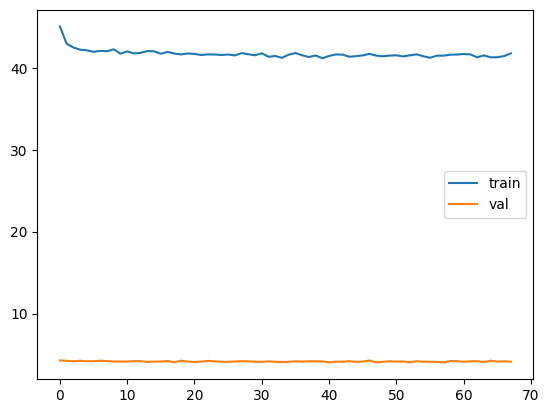

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(),lr=1)
trainHistory=[]
valHistory=[]
lrScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

bestLoss = float('inf')
for phase in range(3):
    cnt = 0
    bestModel = model

    while(cnt<10):
        model.train()
        trainLoss=0
        for  _, x, y in trainLoader:
            # Compute prediction error
            pred = model(x)
            loss = loss_fn(pred, y)
            trainLoss +=loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        valLoss=0
        with torch.no_grad():
            for _, x,y in valLoader:
                pred = model(x)
                loss = loss_fn(pred, y)
                valLoss+=loss.item()

        trainHistory.append(trainLoss)

        valHistory.append(valLoss)

        if bestLoss < valLoss:
            cnt +=1
        else:
            bestLoss = valLoss
            bestModel = model
            cnt =0 

        print(f'{lrScheduler.get_last_lr()} cnt: {cnt} - val loss: {valLoss} - train loss: {trainLoss}')

    model = bestModel
    torch.save(model.state_dict(), 'model.pt')
    lrScheduler.step()

plt.plot(trainHistory,label='train')
plt.plot(valHistory, label='val')
plt.legend() 

In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for _, x, y  in valLoader:
        pred = model(x)

        for idx, i in enumerate(pred):
            if torch.argmax(i)== torch.argmax(y[idx]):
                correct +=1 
            total+=1
correct / total


0.808984375

In [20]:
model.eval()
result = []
with torch.no_grad():
    for id, X, _ in testLoader:
        pred = model(X)
        for idx, i in enumerate(pred):
            result.append([id[idx], torch.argmax(i).item()])

result

7669866

In [21]:
outDF= pd.DataFrame(result)
outDF= outDF.astype(int)
outDF.columns=['id','Response']
outDF

,id,Response
0,11504798,0
1,11504799,1
2,11504800,1
3,11504801,0
4,11504802,0
...,...,...
7669861,19174659,1
7669862,19174660,0
7669863,19174661,0
7669864,19174662,1


In [22]:
outDF.to_csv('result.csv',index=False)